In [1]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
air_quality = fetch_ucirepo(id=360)

# data (as pandas dataframes)
Orig_df = air_quality.data.features
y = air_quality.data.targets # y is none

# metadata
print(air_quality.metadata)

# variable information
print(air_quality.variables)

{'uci_id': 360, 'name': 'Air Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/360/air+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/360/data.csv', 'abstract': 'Contains the responses of a gas multisensor device deployed on the field in an Italian city. Hourly responses averages are recorded along with gas concentrations references from a certified analyzer. ', 'area': 'Computer Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 9358, 'num_features': 15, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Sun Mar 10 2024', 'dataset_doi': '10.24432/C59K5F', 'creators': ['Saverio Vito'], 'intro_paper': {'ID': 420, 'type': 'NATIVE', 'title': 'On field calibration of an electronic nose for benzene estimation in an urban pollution monitoring scenario', 'authors': 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

### Data cleaning

In [ ]:
#print(X.head())
#print(X.shape)

# filter out missing data
Orig_df.replace(-200, np.nan, inplace=True)
summary = Orig_df.describe()
# print(summary)
df=Orig_df.dropna()
print(df.shape) # filter out, we get a small dataframe because the experimental sensor of NMHC broke so we lost many data

(827, 15)


### Data exploration

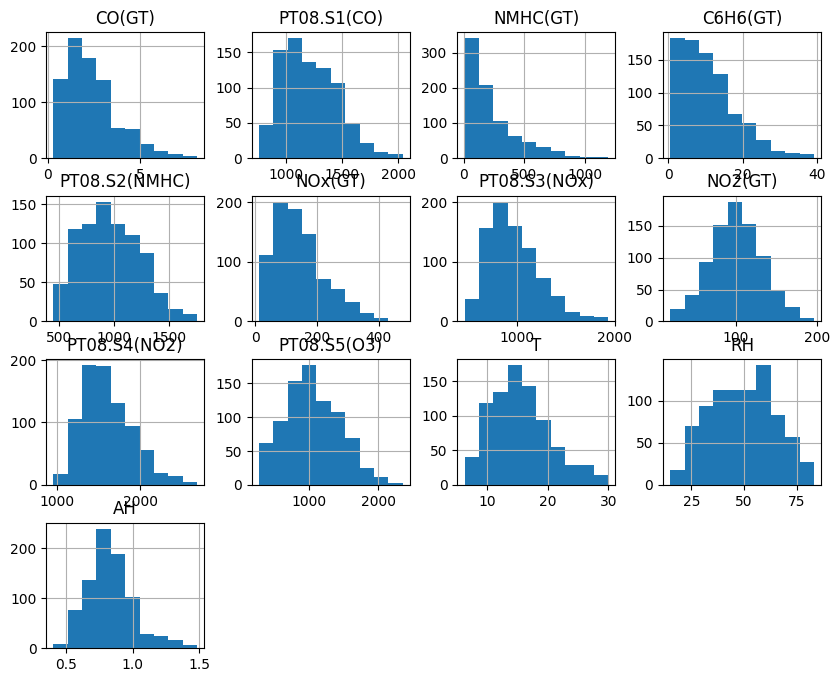

In [ ]:
# histogram of each avariables
df.hist(bins=10, figsize=(10, 8))
plt.show()

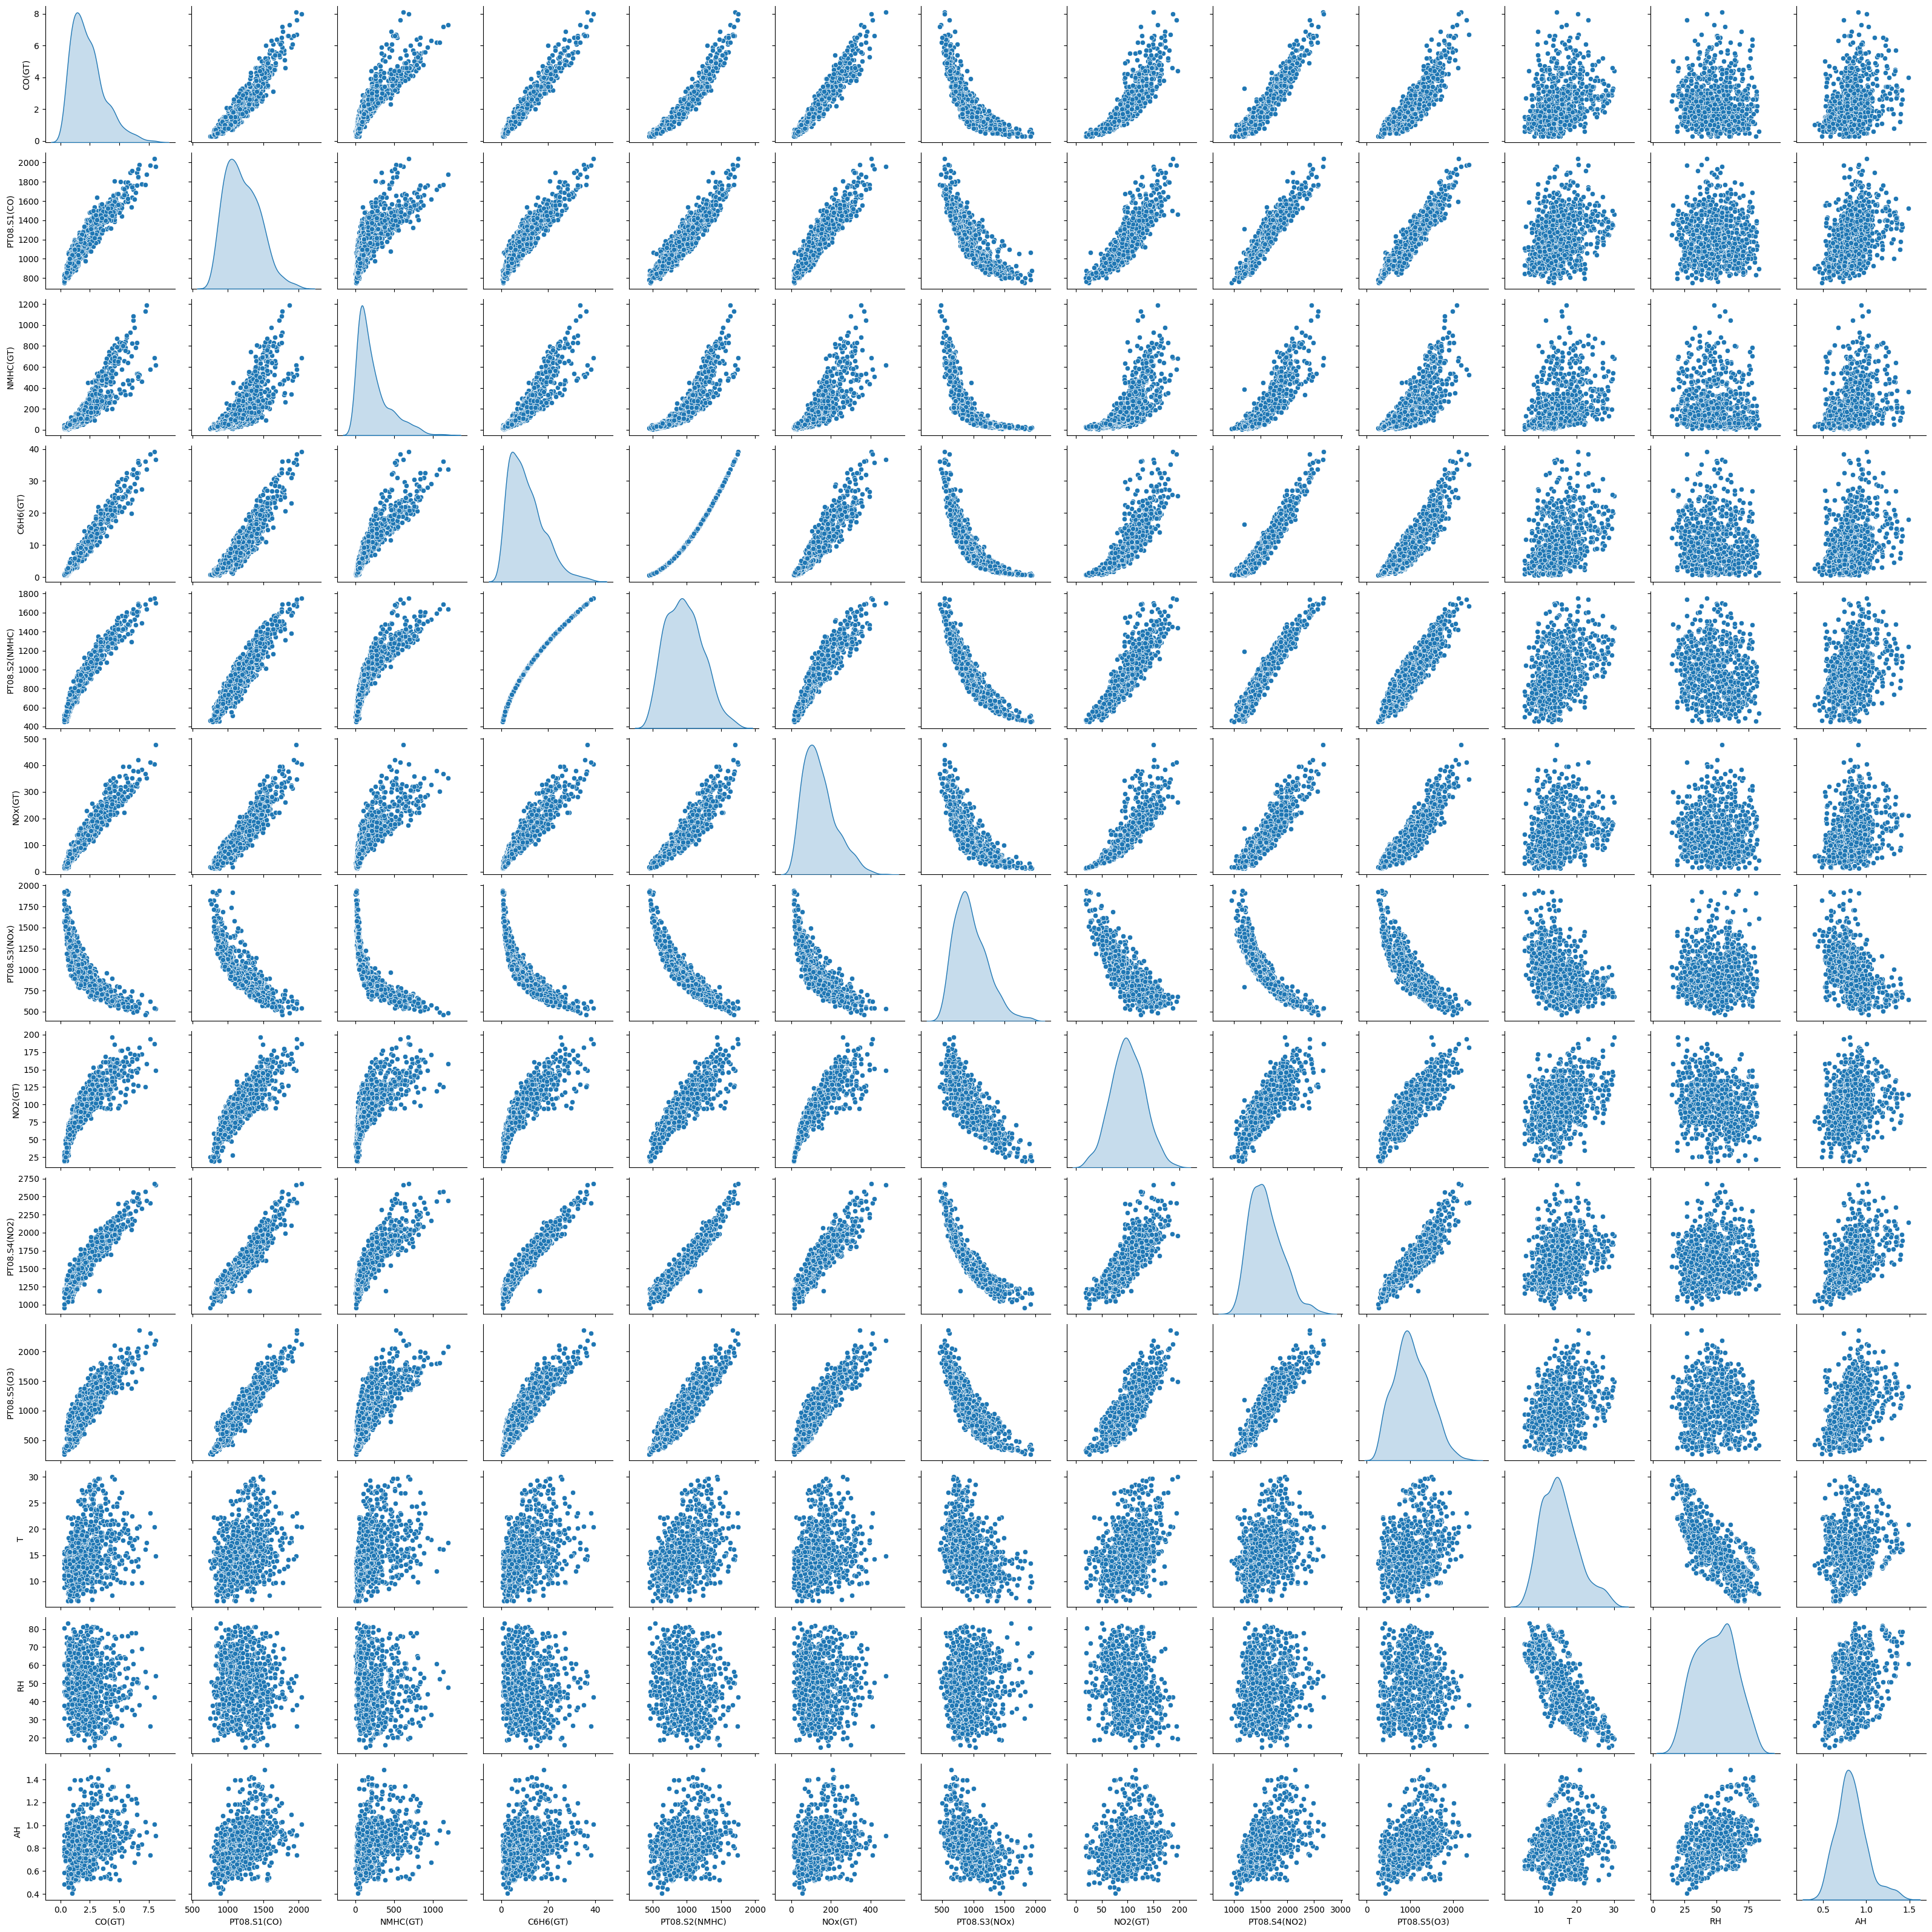

In [ ]:
# pairwise scatterplot
sns.pairplot(df, diag_kind='kde')

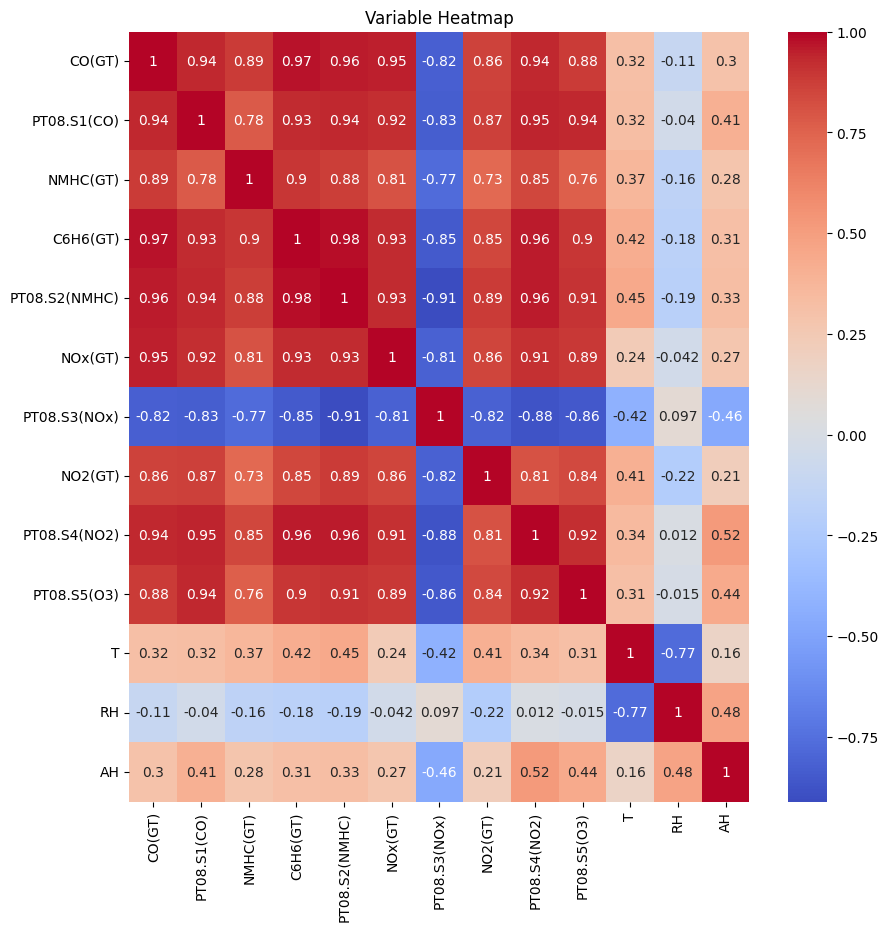

In [ ]:
corr = df.select_dtypes(include='number').corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, cmap="coolwarm", annot=True)
plt.title("Variable Heatmap") # problem: categorical variable included, is that a correct inclusion?
plt.show()

### Full model elastic regression

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNetCV # elastic regression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import enet_path

In [ ]:
# extract X and y(benzene concentration) from df
X = df.drop(["C6H6(GT)", "Date", "Time"], axis=1)
y = df["C6H6(GT)"]
print(X.head())
print(y.head())

   CO(GT)  PT08.S1(CO)  NMHC(GT)  PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  \
0     2.6       1360.0     150.0         1046.0    166.0        1056.0   
1     2.0       1292.0     112.0          955.0    103.0        1174.0   
2     2.2       1402.0      88.0          939.0    131.0        1140.0   
3     2.2       1376.0      80.0          948.0    172.0        1092.0   
4     1.6       1272.0      51.0          836.0    131.0        1205.0   

   NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH  
0    113.0        1692.0       1268.0  13.6  48.9  0.7578  
1     92.0        1559.0        972.0  13.3  47.7  0.7255  
2    114.0        1555.0       1074.0  11.9  54.0  0.7502  
3    122.0        1584.0       1203.0  11.0  60.0  0.7867  
4    116.0        1490.0       1110.0  11.2  59.6  0.7888  
0    11.9
1     9.4
2     9.0
3     9.2
4     6.5
Name: C6H6(GT), dtype: float64


In [ ]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

In [ ]:
# Apply elastic regression
alpha_values = [0.1, 1.0, 10]
model = ElasticNetCV(alphas = alpha_values, cv=5, random_state=100)
model.fit(X_train, y_train)

ElasticNetCV(alphas=[0.1, 1.0, 10], cv=5, random_state=100)

In [ ]:
# make prediction
y_pred = model.predict(X_test)
# compute R2, and MSE
R2 = r2_score(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
# make them into a dataframe
data = {
    "R square": [R2],
    "MSE": [MSE]
}
metric_table = pd.DataFrame(data)
print(model.alpha_) # best alpha value ElasticNetCV chose
print(metric_table)

0.1
   R square       MSE
0  0.992453  0.458819


### Check which variables are selected

In [ ]:
coefs = pd.Series(model.coef_, index=X.columns)
# print(coefs)
selected = coefs[coefs != 0]
print("Selected variables:", selected.index.tolist())

Selected variables: ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH']


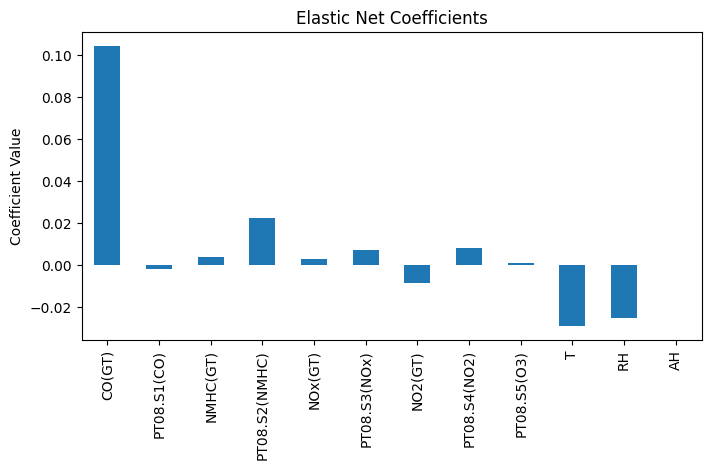

In [ ]:
# plot the coefficients
coefs.plot(kind="bar", figsize=(8, 4))
plt.title("Elastic Net Coefficients")
plt.ylabel("Coefficient Value")
plt.show()

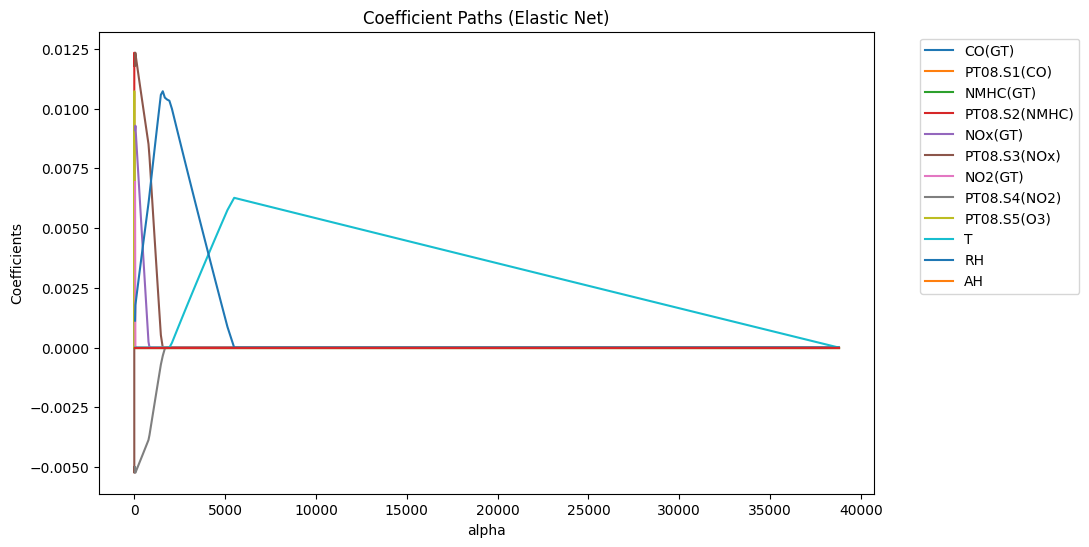

In [ ]:
# coefficient path
alphas, coefs, _ = enet_path(X, y, l1_ratio=model.l1_ratio_)

plt.figure(figsize=(10, 6))
for i, col_name in enumerate(X.columns):
    plt.plot(-np.log10(alphas), coefs[i, :], label=col_name)

plt.plot(alphas, coefs.T)
plt.xlabel("alpha")
plt.ylabel("Coefficients")
plt.title("Coefficient Paths (Elastic Net)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()